In [1]:
import os
import torch

# -----------------------------------------------------------------------------
# Shared Configuration for Both Models
# -----------------------------------------------------------------------------

SHARED_CONFIG = {
    # Data parameters
    'MAX_STORIES': 2000,                # Number of stories to use for training
    
    # Training parameters
    'EPOCHS': 4,                       # Number of training epochs
    'BATCH_SIZE': 32,                  # Batch size for training
    'BLOCK_SIZE': 128,                 # Context size for training
    'DEVICE': 'cuda' if torch.cuda.is_available() else 'cpu',
    
    # Evaluation parameters
    'EVAL_INTERVAL': 1000,              # Steps between evaluations
    'EVAL_ITER': 50,                   # Number of batches for evaluation
    'MAX_OUT_TOKENS': 100,             # Number of tokens to generate for samples
    
    # File paths
    'RESERVOIR_SAVE_PATH': 'models/deep_reservoir_trained.pt',
    'TRANSFORMER_SAVE_PATH': 'models/tiny_lm_trained.pt'
}

print(f"Using device: {SHARED_CONFIG['DEVICE']}")
os.makedirs("models", exist_ok=True)

Using device: cpu


In [2]:
# -----------------------------------------------------------------------------
# Import Common Libraries
# -----------------------------------------------------------------------------
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from tqdm import tqdm
from transformers import GPT2TokenizerFast
from datasets import load_dataset
import matplotlib.pyplot as plt


# -----------------------------------------------------------------------------
# Data Download and Tokenization
# -----------------------------------------------------------------------------

# Initialize tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def download_and_save_dataset(max_stories=None):
    """Downloads the TinyStories dataset and saves a subset if specified."""
    data_dir = "data"
    if max_stories:
        train_path = os.path.join(data_dir, f"TinyStories-train-{max_stories}.txt")
        valid_path = os.path.join(data_dir, f"TinyStories-valid-{max_stories}.txt")
    else:
        train_path = os.path.join(data_dir, "TinyStories-train.txt")
        valid_path = os.path.join(data_dir, "TinyStories-valid.txt")

    if os.path.exists(train_path) and os.path.exists(valid_path):
        print(f"Dataset files already exist: {train_path}, {valid_path}")
        return train_path, valid_path

    print("Downloading TinyStories dataset from Hugging Face...")
    os.makedirs(data_dir, exist_ok=True)
    ds = load_dataset("roneneldan/TinyStories")

    print(f"Saving training split to {train_path}...")
    with open(train_path, 'w', encoding='utf-8') as f:
        for i, story in enumerate(tqdm(ds['train'])):
            if max_stories and i >= max_stories:
                break
            f.write(story['text'] + '\n')

    print(f"Saving validation split to {valid_path}...")
    with open(valid_path, 'w', encoding='utf-8') as f:
        val_stories_to_save = max_stories // 10 if max_stories else None
        for i, story in enumerate(tqdm(ds['validation'])):
            if val_stories_to_save and i >= val_stories_to_save:
                break
            f.write(story['text'] + '\n')
    return train_path, valid_path

def pre_tokenize_dataset(path, save_path):
    print(f"Running tokenization for {path}...")
    with open(path, 'r', encoding='utf-8') as file:
        text = file.read()
        tokens = tokenizer.encode(text)
        np.save(save_path, np.array(tokens, dtype=np.int32))
        print(f"Saved tokenized file to binary {save_path}")

class TinyStoriesDataset(data.Dataset):
    def __init__(self, tokenized_path, block_size: int):
        self.block_size = block_size
        self.data = np.load(tokenized_path, mmap_mode='r')

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        chunk = self.data[idx:idx + self.block_size + 1]
        source = torch.from_numpy(chunk[:-1].astype(np.int64))
        target = torch.from_numpy(chunk[1:].astype(np.int64))
        return source, target

ModuleNotFoundError: No module named 'transformers'

In [10]:
# -----------------------------------------------------------------------------
# Download and Prepare Dataset
# -----------------------------------------------------------------------------

# Download dataset
train_txt_path, val_txt_path = download_and_save_dataset(max_stories=SHARED_CONFIG["MAX_STORIES"])

# Tokenize training data
train_tokenized_path = train_txt_path.replace('.txt', '.npy')
if not os.path.exists(train_tokenized_path):
    pre_tokenize_dataset(train_txt_path, train_tokenized_path)

# Tokenize validation data
val_tokenized_path = val_txt_path.replace('.txt', '.npy')
if not os.path.exists(val_tokenized_path):
    pre_tokenize_dataset(val_txt_path, val_tokenized_path)

# Create data loaders
train_dataset = TinyStoriesDataset(train_tokenized_path, SHARED_CONFIG['BLOCK_SIZE'])
train_loader = data.DataLoader(train_dataset, batch_size=SHARED_CONFIG['BATCH_SIZE'], shuffle=True)

val_dataset = TinyStoriesDataset(val_tokenized_path, SHARED_CONFIG['BLOCK_SIZE'])
val_loader = data.DataLoader(val_dataset, batch_size=SHARED_CONFIG['BATCH_SIZE'])

print(f"Data preparation complete! Tokenizer vocabulary size: {tokenizer.vocab_size}")

Saving training split to data/TinyStories-train-100.txt...


  0%|          | 100/2119719 [00:00<01:13, 28708.45it/s]


Saving validation split to data/TinyStories-valid-100.txt...


  0%|          | 10/21990 [00:00<00:02, 10538.45it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (18887 > 1024). Running this sequence through the model will result in indexing errors


Running tokenization for data/TinyStories-train-100.txt...
Saved tokenized file to binary data/TinyStories-train-100.npy
Running tokenization for data/TinyStories-valid-100.txt...
Saved tokenized file to binary data/TinyStories-valid-100.npy
Data preparation complete! Tokenizer vocabulary size: 50257


In [11]:
class OptimizedParallelReservoir(nn.Module):
    """
    Memory and computation optimized reservoir with gradient checkpointing support.
    """
    def __init__(self, input_size, hidden_size, window_size, spectral_radius=1.2,
                 sparsity=0.1, activation='tanh', device='cuda'):
        super().__init__()
        self.window_size = window_size
        self.device = device
        self.hidden_size = hidden_size
        
        # Use smaller precision for reservoir weights to save memory
        self.projection = nn.Linear(input_size * window_size, hidden_size, bias=False, dtype=torch.float16).to(device)
        self._initialize_weights(spectral_radius, sparsity)
        
        # Precompute activation function
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'leaky_relu':
            self.activation = lambda x: F.leaky_relu(x, 0.01, inplace=True)  # Small negative slope, inplace
        elif activation == 'gelu':
            self.activation = F.gelu
        else:
            raise ValueError("Unsupported activation function")

    def _initialize_weights(self, spectral_radius, sparsity):
        # Freeze reservoir weights
        for param in self.projection.parameters():
            param.requires_grad = False

        with torch.no_grad():
            W = self.projection.weight.data
            
            # More efficient spectral radius normalization
            if W.shape[0] == W.shape[1]:
                # Use power iteration for large matrices (more efficient than full eigendecomposition)
                if W.shape[0] > 512:
                    current_radius = self._power_iteration_spectral_radius(W)
                else:
                    eigenvalues = torch.linalg.eigvals(W)
                    current_radius = torch.max(torch.abs(eigenvalues))
                W *= spectral_radius / current_radius
            
            # Apply sparsity mask
            mask = (torch.rand(W.shape, device=self.device) > sparsity)
            W *= mask.to(W.dtype)

    def _power_iteration_spectral_radius(self, W, num_iterations=10):
        """Estimate spectral radius using power iteration (more efficient for large matrices)"""
        v = torch.randn(W.shape[1], device=W.device, dtype=W.dtype)
        for _ in range(num_iterations):
            v = torch.mv(W, v)
            v = v / torch.norm(v)
        return torch.norm(torch.mv(W, v))

    def forward(self, x):
        # More memory-efficient windowing using stride tricks
        batch_size, seq_len, input_size = x.shape
        
        # Pad only what we need
        if self.window_size > 1:
            padding = (0, 0, self.window_size - 1, 0)
            x_padded = F.pad(x, padding, "constant", 0)
        else:
            x_padded = x
            
        # Use unfold for efficient windowing
        windows = x_padded.unfold(1, self.window_size, 1)
        windows_flat = windows.contiguous().view(batch_size, seq_len, -1)
        
        # Convert to float16 for computation, back to float32 for output
        windows_flat = windows_flat.to(torch.float16)
        output = self.activation(self.projection(windows_flat))
        return output.to(torch.float32)


class OptimizedReservoirBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.reservoirs = nn.ModuleList()
        total_reservoir_size = 0
        
        for res_config in config['reservoirs_per_block']:
            self.reservoirs.append(
                OptimizedParallelReservoir(
                    input_size=config['embedding_dim'],
                    hidden_size=res_config['reservoir_size'],
                    window_size=res_config['window_size'],
                    spectral_radius=res_config['spectral_radius'],
                    sparsity=res_config.get('sparsity', 0.1),
                    activation=res_config.get('activation', 'gelu'),  # GELU often works better
                    device=config['DEVICE']
                )
            )
            total_reservoir_size += res_config['reservoir_size']

        # Simplified readout with better initialization
        self.readout = nn.Sequential(
            nn.LayerNorm(total_reservoir_size),  # Add layer norm for stability
            nn.Linear(total_reservoir_size, config['readout_hidden_size']),
            nn.GELU(),
            nn.Dropout(config.get('dropout', 0.1)),  # Reduced dropout
            nn.Linear(config['readout_hidden_size'], config['embedding_dim'])
        )
        
        # Initialize readout weights properly
        self._init_readout_weights()

    def _init_readout_weights(self):
        for module in self.readout.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, x):
        # Use gradient checkpointing for memory efficiency during training
        if self.training and hasattr(torch.utils.checkpoint, 'checkpoint'):
            reservoir_states = [torch.utils.checkpoint.checkpoint(res, x, use_reentrant=False) 
                              for res in self.reservoirs]
        else:
            reservoir_states = [res(x) for res in self.reservoirs]
            
        combined_states = torch.cat(reservoir_states, dim=-1)
        update_vector = self.readout(combined_states)
        return update_vector


class OptimizedDeepReservoirModel(nn.Module):
    def __init__(self, vocab_size, config):
        super().__init__()
        
        # Trainable embedding with proper initialization
        self.embedding = nn.Embedding(vocab_size, config['embedding_dim'])
        nn.init.normal_(self.embedding.weight, mean=0, std=0.02)
        
        # Add positional encoding for better sequence understanding
        self.pos_encoding = nn.Parameter(
            torch.randn(config['max_seq_len'], config['embedding_dim']) * 0.02
        )
        
        # Input projection to stabilize training
        self.input_proj = nn.Sequential(
            nn.LayerNorm(config['embedding_dim']),
            nn.Linear(config['embedding_dim'], config['embedding_dim']),
            nn.GELU()
        )
        
        self.blocks = nn.ModuleList([
            OptimizedReservoirBlock(config) for _ in range(config['num_blocks'])
        ])
        
        # Output head with better initialization
        self.output_norm = nn.LayerNorm(config['embedding_dim'])
        self.final_head = nn.Linear(config['embedding_dim'], vocab_size, bias=False)
        
        # Tie weights between embedding and output (common practice)
        if config.get('tie_weights', True):
            self.final_head.weight = self.embedding.weight
        
        self._init_weights()

    def _init_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear) and module != self.final_head:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)

    def forward(self, idx):
        batch_size, seq_len = idx.shape
        
        # Embedding + positional encoding
        x_emb = self.embedding(idx)
        pos_emb = self.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
        x = self.input_proj(x_emb + pos_emb)
        
        # Reservoir blocks with residual connections
        for block in self.blocks:
            update = block(x)
            x = x + update  # Residual connection
        
        # Output projection
        x = self.output_norm(x)
        logits = self.final_head(x)
        return logits


@torch.no_grad()
def eval_reservoir_model(model, data_loader, config):
    """Evaluates the reservoir model with mixed precision."""
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    num_batches = 0
    
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        for x, y in data_loader:
            if num_batches >= config['EVAL_ITER']:
                break
            x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
            logits = model(x)
            B, T, C = logits.shape
            loss = criterion(logits.view(B * T, C), y.view(B * T))
            total_loss += loss.item()
            num_batches += 1
    
    model.train()
    return total_loss / num_batches if num_batches > 0 else float('inf')


@torch.no_grad()
def generate_from_reservoir(model, context_str, max_new_tokens, config, tokenizer):
    """Generates text from the reservoir model with temperature sampling."""
    model.eval()
    start_indices = tokenizer.encode(context_str)
    context = torch.tensor(start_indices, dtype=torch.long, device=config['DEVICE']).unsqueeze(0)
    
    temperature = config.get('temperature', 0.8)
    top_k = config.get('top_k', 50)

    for _ in range(max_new_tokens):
        current_context = context[:, -config['BLOCK_SIZE']:]
        
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            logits = model(current_context)
            
        logits = logits[:, -1, :] / temperature
        
        # Top-k sampling
        if top_k > 0:
            top_k_logits, top_k_indices = torch.topk(logits, top_k)
            logits = torch.full_like(logits, float('-inf'))
            logits.scatter_(1, top_k_indices, top_k_logits)
        
        probs = torch.nn.functional.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        context = torch.cat((context, idx_next), dim=1)

    model.train()
    return tokenizer.decode(context.squeeze().tolist())


def create_optimized_reservoir_config(shared_config, train_loader):
    """Create optimized reservoir config based on dataset size and shared config."""
    
    # Calculate training steps based on actual dataset
    steps_per_epoch = len(train_loader)
    total_steps = steps_per_epoch * shared_config['EPOCHS']
    
    # Calculate warmup and scheduling parameters
    warmup_steps = min(1000, total_steps // 10)  # 10% of training or 1000 steps, whichever is smaller
    
    config = {
        # Model architecture
        'embedding_dim': 384,  # Slightly smaller for efficiency
        'num_blocks': 3,       # More blocks, each smaller
        'max_seq_len': shared_config['BLOCK_SIZE'] * 2,  # Based on your block size
        'tie_weights': True,   # Tie embedding and output weights
        'dropout': 0.1,
        
        'reservoirs_per_block': [
            # Fewer, more focused reservoirs per block
            {'reservoir_size': 192, 'window_size': min(64, shared_config['BLOCK_SIZE']//2), 
             'spectral_radius': 0.95, 'sparsity': 0.2, 'activation': 'gelu'},
            {'reservoir_size': 256, 'window_size': min(32, shared_config['BLOCK_SIZE']//4), 
             'spectral_radius': 1.05, 'sparsity': 0.15, 'activation': 'gelu'},
        ],
        'readout_hidden_size': 192,
        
        # Training params from shared config
        'BATCH_SIZE': shared_config['BATCH_SIZE'],
        'BLOCK_SIZE': shared_config['BLOCK_SIZE'],
        'EVAL_INTERVAL': shared_config['EVAL_INTERVAL'],
        'EVAL_ITER': shared_config['EVAL_ITER'],
        'DEVICE': shared_config['DEVICE'],
        'EPOCHS': shared_config['EPOCHS'],
        'SAVE_PATH': shared_config['RESERVOIR_SAVE_PATH'],
        
        # Calculated training parameters
        'steps_per_epoch': steps_per_epoch,
        'total_steps': total_steps,
        'warmup_steps': warmup_steps,
        
        # Optimized learning parameters
        'LR': 3e-4,           # Higher initial learning rate
        'weight_decay': 0.01,  # L2 regularization
        'accumulation_steps': 4,  # Gradient accumulation
        
        # Generation parameters
        'temperature': 0.8,
        'top_k': 50,
    }
    
    print(f"Training configuration:")
    print(f"  Dataset size: {len(train_loader.dataset):,} sequences")
    print(f"  Steps per epoch: {steps_per_epoch:,}")
    print(f"  Total training steps: {total_steps:,}")
    print(f"  Warmup steps: {warmup_steps:,}")
    print(f"  Effective batch size: {config['BATCH_SIZE'] * config['accumulation_steps']}")
    
    return config


def get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps):
    """Creates a cosine annealing scheduler with warmup based on actual training steps."""
    def lr_lambda(step):
        if step < warmup_steps:
            # Linear warmup
            return step / warmup_steps
        elif total_steps <= warmup_steps:
            # Edge case: no cosine annealing phase, maintain warmup final value
            return 1.0
        else:
            # Cosine annealing
            progress = (step - warmup_steps) / (total_steps - warmup_steps)
            return 0.5 * (1 + np.cos(np.pi * progress))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


# Training function with all optimizations
def train_optimized_reservoir_model(model, train_loader, val_loader, config, tokenizer, shared_config):
    """Optimized training loop with mixed precision, gradient accumulation, and cosine scheduling."""
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=config['LR'], 
        weight_decay=config['weight_decay'],
        betas=(0.9, 0.95)  # Better betas for language modeling
    )
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, 
        config['warmup_steps'], 
        config['total_steps']
    )
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    # Gradient accumulation
    accumulation_steps = config['accumulation_steps']
    
    train_losses = []
    val_perplexities = []
    learning_rates = []
    steps = []
    total_batches = 0
    
    print("Starting Optimized Reservoir Model training...")
    print(f"Training for {config['EPOCHS']} epochs, {config['total_steps']} total steps")
    
    model.train()
    optimizer.zero_grad()
    
    for epoch in range(config['EPOCHS']):
        print(f"\n--- Epoch {epoch + 1}/{config['EPOCHS']} ---")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch + 1}")
        
        for x, y in pbar:
            total_batches += 1
            x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
            
            # Mixed precision forward pass
            with torch.autocast(device_type='cuda', dtype=torch.float16):
                logits = model(x)
                B, T, C = logits.shape
                loss = criterion(logits.view(B * T, C), y.view(B * T))
                loss = loss / accumulation_steps  # Scale loss for accumulation
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            if total_batches % accumulation_steps == 0:
                # Gradient clipping
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                
                # Optimizer step
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()
            
            train_losses.append(loss.item() * accumulation_steps)  # Unscale for logging
            current_lr = scheduler.get_last_lr()[0]
            learning_rates.append(current_lr)
            
            pbar.set_postfix({
                'loss': f"{loss.item() * accumulation_steps:.4f}",
                'lr': f"{current_lr:.2e}",
                'step': f"{total_batches}/{config['total_steps']}"
            })
            
            # Evaluation
            if total_batches % config['EVAL_INTERVAL'] == 0:
                val_loss = eval_reservoir_model(model, val_loader, config)
                perplexity = np.exp(val_loss)
                val_perplexities.append(perplexity)
                steps.append(total_batches)
                
                print(f"\nStep {total_batches}: Val Loss: {val_loss:.4f}, Perplexity: {perplexity:.4f}")
                
                # Generate sample
                generated_text = generate_from_reservoir(
                    model, "Once upon a time", shared_config['MAX_OUT_TOKENS'], config, tokenizer
                )
                print("Generated:", generated_text[:150] + "...")
            
            # Stop if we've reached the total steps
            if total_batches >= config['total_steps']:
                break
        
        # Break from epoch loop if we've reached total steps
        if total_batches >= config['total_steps']:
            break
    
    print(f"\nTraining completed! Total steps: {total_batches}")
    
    return {
        'train_losses': train_losses,
        'val_perplexities': val_perplexities,
        'learning_rates': learning_rates,
        'steps': steps
    }

optimized_reservoir_config = create_optimized_reservoir_config(SHARED_CONFIG, train_loader)

optimized_model = OptimizedDeepReservoirModel(
    vocab_size=tokenizer.vocab_size,
    config=optimized_reservoir_config
).to(optimized_reservoir_config['DEVICE'])

print(f"Optimized model: {sum(p.numel() for p in optimized_model.parameters() if p.requires_grad):,} trainable parameters")

Optimized model: 20,128,320 trainable parameters


In [ ]:
# -----------------------------------------------------------------------------
# Ridge Regression Layer-wise Training Implementation
# -----------------------------------------------------------------------------

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import gc

def collect_reservoir_states_and_targets(model, data_loader, layer_idx, config, max_batches=None):
    """
    Collect reservoir states and target embeddings for a specific layer.
    
    Args:
        model: The OptimizedDeepReservoirModel
        data_loader: Training data loader
        layer_idx: Index of the layer to collect states from (0-based)
        config: Model configuration
        max_batches: Maximum number of batches to process (None for all)
    
    Returns:
        H: Concatenated reservoir states from all reservoirs in the layer [N, total_reservoir_size]
        Y: Target embeddings [N, embedding_dim]
    """
    model.eval()
    
    H_list = []
    Y_list = []
    
    print(f"Collecting states for layer {layer_idx}...")
    
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(tqdm(data_loader)):
            if max_batches and batch_idx >= max_batches:
                break
                
            x = x.to(config['DEVICE'])
            y = y.to(config['DEVICE'])
            
            batch_size, seq_len = x.shape
            
            # Forward pass up to the target layer
            # 1. Embedding + positional encoding
            x_emb = model.embedding(x)
            pos_emb = model.pos_encoding[:seq_len].unsqueeze(0).expand(batch_size, -1, -1)
            current_x = model.input_proj(x_emb + pos_emb)
            
            # 2. Pass through reservoir blocks up to layer_idx
            for block_idx in range(layer_idx):
                update = model.blocks[block_idx](current_x)
                current_x = current_x + update  # Residual connection
            
            # 3. Get reservoir states from the target layer (before readout)
            target_block = model.blocks[layer_idx]
            
            # Get states from all reservoirs in this block
            reservoir_states = []
            for res in target_block.reservoirs:
                state = res(current_x)  # [batch_size, seq_len, reservoir_size]
                reservoir_states.append(state)
            
            # Concatenate all reservoir states
            combined_states = torch.cat(reservoir_states, dim=-1)  # [batch_size, seq_len, total_reservoir_size]
            
            # 4. Get target embeddings (next token embeddings)
            # Shift y to get next tokens, and get their embeddings
            y_shifted = y  # y is already the next token for each position
            target_embeddings = model.embedding(y_shifted)  # [batch_size, seq_len, embedding_dim]
            
            # 5. Flatten batch and sequence dimensions
            H_batch = combined_states.view(-1, combined_states.shape[-1])  # [batch_size * seq_len, total_reservoir_size]
            Y_batch = target_embeddings.view(-1, target_embeddings.shape[-1])  # [batch_size * seq_len, embedding_dim]
            
            H_list.append(H_batch.cpu())
            Y_list.append(Y_batch.cpu())
            
            # Clear GPU memory
            del x, y, x_emb, pos_emb, current_x, combined_states, target_embeddings, H_batch, Y_batch
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
    
    # Concatenate all batches
    H = torch.cat(H_list, dim=0).numpy()  # [total_samples, total_reservoir_size]
    Y = torch.cat(Y_list, dim=0).numpy()  # [total_samples, embedding_dim]
    
    print(f"Collected {H.shape[0]} samples with {H.shape[1]} reservoir features and {Y.shape[1]} target dimensions")
    return H, Y


def train_layer_with_ridge_regression(model, H, Y, layer_idx, config, alpha=1.0, normalize=True):
    """
    Train a specific layer's readout using Ridge regression.
    
    Args:
        model: The OptimizedDeepReservoirModel
        H: Reservoir states [N, total_reservoir_size]
        Y: Target embeddings [N, embedding_dim]
        layer_idx: Index of the layer to train
        config: Model configuration
        alpha: Ridge regression regularization parameter
        normalize: Whether to normalize features
    """
    print(f"Training layer {layer_idx} readout with Ridge regression (alpha={alpha})...")
    
    target_block = model.blocks[layer_idx]
    readout = target_block.readout
    
    # Find the final linear layer in the readout
    final_linear = None
    for module in reversed(list(readout.modules())):
        if isinstance(module, nn.Linear):
            final_linear = module
            break
    
    if final_linear is None:
        raise ValueError("Could not find final linear layer in readout")
    
    # Get the expected input size (after layer norm and first linear + activation)
    # We need to pass H through the readout up to the final layer
    with torch.no_grad():
        # Convert H back to tensor for forward pass
        H_tensor = torch.from_numpy(H).float().to(config['DEVICE'])
        
        # Pass through readout layers except the final one
        x = H_tensor
        for i, module in enumerate(readout.children()):
            if module == final_linear:
                break
            x = module(x)
        
        # Get the features for ridge regression
        H_features = x.cpu().numpy()
    
    print(f"Ridge regression input shape: {H_features.shape}, target shape: {Y.shape}")
    
    # Optional feature normalization
    scaler = None
    if normalize:
        scaler = StandardScaler()
        H_features = scaler.fit_transform(H_features)
    
    # Train Ridge regression for each output dimension
    # We can vectorize this by training on all output dimensions at once
    ridge = Ridge(alpha=alpha, fit_intercept=True)
    ridge.fit(H_features, Y)
    
    # Calculate R² score before cleanup
    r2_score = ridge.score(H_features, Y)
    print(f"Ridge regression R² score: {r2_score:.4f}")
    
    # Extract learned weights and bias
    W_out = ridge.coef_.T  # [input_features, embedding_dim]
    b_out = ridge.intercept_  # [embedding_dim]
    
    # Set the weights and bias in the PyTorch model
    with torch.no_grad():
        final_linear.weight.data = torch.from_numpy(W_out.T).float().to(config['DEVICE'])
        if final_linear.bias is not None:
            final_linear.bias.data = torch.from_numpy(b_out).float().to(config['DEVICE'])
    
    print(f"Updated layer {layer_idx} readout weights: {W_out.T.shape} and bias: {b_out.shape}")
    
    # Clean up memory
    del H_tensor, H_features, Y
    gc.collect()
    torch.cuda.empty_cache()
    
    return r2_score


def greedy_layerwise_training(model, train_loader, config, alpha=1.0, max_batches_per_layer=None, normalize=True):
    """
    Perform greedy layer-wise training using Ridge regression.
    
    Args:
        model: The OptimizedDeepReservoirModel
        train_loader: Training data loader
        config: Model configuration
        alpha: Ridge regression regularization parameter
        max_batches_per_layer: Maximum batches to use per layer (None for all)
        normalize: Whether to normalize features for Ridge regression
    
    Returns:
        List of R² scores for each layer
    """
    print("=" * 80)
    print("Starting Greedy Layer-wise Training with Ridge Regression")
    print("=" * 80)
    
    num_layers = len(model.blocks)
    r2_scores = []
    
    for layer_idx in range(num_layers):
        print(f"\n--- Training Layer {layer_idx + 1}/{num_layers} ---")
        
        # Collect reservoir states and targets for this layer
        H, Y = collect_reservoir_states_and_targets(
            model, train_loader, layer_idx, config, max_batches_per_layer
        )
        
        # Train this layer's readout with Ridge regression
        r2_score = train_layer_with_ridge_regression(
            model, H, Y, layer_idx, config, alpha, normalize
        )
        r2_scores.append(r2_score)
        
        print(f"Layer {layer_idx} R² score: {r2_score:.4f}")
        
        # Clean up memory
        del H, Y
        gc.collect()
        torch.cuda.empty_cache()
    
    print("\n" + "=" * 80)
    print("Layer-wise Training Complete!")
    print("=" * 80)
    print("R² Scores by Layer:")
    for i, score in enumerate(r2_scores):
        print(f"  Layer {i}: {score:.4f}")
    print(f"  Average: {np.mean(r2_scores):.4f}")
    
    return r2_scores


def evaluate_layerwise_model(model, val_loader, config):
    """
    Evaluate the model trained with layer-wise Ridge regression.
    """
    print("Evaluating layer-wise trained model...")
    
    model.eval()
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    num_batches = 0
    
    with torch.no_grad():
        for x, y in val_loader:
            if num_batches >= config['EVAL_ITER']:
                break
            x, y = x.to(config['DEVICE']), y.to(config['DEVICE'])
            
            # Forward pass through the full model
            logits = model(x)
            B, T, C = logits.shape
            loss = criterion(logits.view(B * T, C), y.view(B * T))
            total_loss += loss.item()
            num_batches += 1
    
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')
    perplexity = np.exp(avg_loss)
    
    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation Perplexity: {perplexity:.4f}")
    
    return avg_loss, perplexity

In [ ]:
# -----------------------------------------------------------------------------
# Apply Ridge Regression Layer-wise Training
# -----------------------------------------------------------------------------

# Create a fresh model for Ridge regression training
print("Creating fresh model for Ridge regression training...")

ridge_model = OptimizedDeepReservoirModel(
    vocab_size=tokenizer.vocab_size,
    config=optimized_reservoir_config
).to(optimized_reservoir_config['DEVICE'])

print(f"Ridge model: {sum(p.numel() for p in ridge_model.parameters() if p.requires_grad):,} trainable parameters")

# Configure Ridge regression parameters
ridge_config = {
    'alpha': 1.0,                    # Ridge regularization strength (try 0.1, 1.0, 10.0)
    'max_batches_per_layer': 50,     # Limit batches per layer for faster training (None for all)
    'normalize': True                # Normalize features for Ridge regression
}

print(f"Ridge regression configuration:")
print(f"  Alpha (regularization): {ridge_config['alpha']}")
print(f"  Max batches per layer: {ridge_config['max_batches_per_layer']}")
print(f"  Feature normalization: {ridge_config['normalize']}")

# Perform layer-wise training
r2_scores = greedy_layerwise_training(
    ridge_model,
    train_loader,
    optimized_reservoir_config,
    alpha=ridge_config['alpha'],
    max_batches_per_layer=ridge_config['max_batches_per_layer'],
    normalize=ridge_config['normalize']
)

# Evaluate the Ridge-trained model
ridge_val_loss, ridge_perplexity = evaluate_layerwise_model(
    ridge_model, val_loader, optimized_reservoir_config
)

print(f"\nRidge-trained model performance:")
print(f"  Validation Loss: {ridge_val_loss:.4f}")
print(f"  Validation Perplexity: {ridge_perplexity:.4f}")

# Generate sample text from Ridge-trained model
print("\n" + "="*60)
print("Sample Generation from Ridge-trained Model")
print("="*60)

sample_text = generate_from_reservoir(
    ridge_model,
    "Once upon a time",
    SHARED_CONFIG['MAX_OUT_TOKENS'],
    optimized_reservoir_config,
    tokenizer
)

print(f"Generated text:\n{sample_text}")

# Save the Ridge-trained model
ridge_save_path = 'models/ridge_reservoir_trained.pt'
torch.save(ridge_model.state_dict(), ridge_save_path)
print(f"\nRidge-trained model saved to: {ridge_save_path}")

In [ ]:
# -----------------------------------------------------------------------------
# Compare Training Approaches
# -----------------------------------------------------------------------------

# Compare the two models
print("=" * 80)
print("TRAINING APPROACH COMPARISON")
print("=" * 80)

# Get final performance metrics from backprop training
if 'training_history' in locals():
    final_train_loss = training_history['train_losses'][-1] if training_history['train_losses'] else 0
    final_val_perplexity = training_history['val_perplexities'][-1] if training_history['val_perplexities'] else 0
    
    print("Backpropagation Training:")
    print(f"  Final Training Loss: {final_train_loss:.4f}")
    print(f"  Final Validation Perplexity: {final_val_perplexity:.4f}")

print(f"\nRidge Regression Training:")
print(f"  Validation Loss: {ridge_val_loss:.4f}")
print(f"  Validation Perplexity: {ridge_perplexity:.4f}")
print(f"  Average R² Score: {np.mean(r2_scores):.4f}")

# Plot comparison
plt.figure(figsize=(15, 10))

# Plot 1: R² scores by layer
plt.subplot(2, 3, 1)
plt.bar(range(len(r2_scores)), r2_scores, alpha=0.7, color='skyblue')
plt.title('Ridge Regression R² Scores by Layer')
plt.xlabel('Layer Index')
plt.ylabel('R² Score')
plt.grid(True, alpha=0.3)
for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

# Plot 2: Training loss comparison (if available)
if 'training_history' in locals():
    plt.subplot(2, 3, 2)
    plt.plot(training_history['train_losses'], label='Backprop Training Loss', alpha=0.7)
    plt.axhline(y=ridge_val_loss, color='red', linestyle='--', 
                label=f'Ridge Val Loss: {ridge_val_loss:.3f}')
    plt.title('Training Loss Comparison')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

# Plot 3: Validation perplexity comparison
plt.subplot(2, 3, 3)
methods = ['Backprop', 'Ridge Regression']
perplexities = []

if 'training_history' in locals() and training_history['val_perplexities']:
    perplexities.append(training_history['val_perplexities'][-1])
else:
    perplexities.append(0)  # No data available

perplexities.append(ridge_perplexity)

bars = plt.bar(methods, perplexities, alpha=0.7, color=['lightgreen', 'lightcoral'])
plt.title('Final Validation Perplexity')
plt.ylabel('Perplexity')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, perplexities):
    if val > 0:
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{val:.2f}', ha='center', va='bottom')

# Plot 4: Model complexity comparison
plt.subplot(2, 3, 4)
total_params = sum(p.numel() for p in ridge_model.parameters())
trainable_params = sum(p.numel() for p in ridge_model.parameters() if p.requires_grad)
reservoir_params = sum(p.numel() for p in ridge_model.parameters() if not p.requires_grad)

params_data = [trainable_params, reservoir_params]
labels = ['Trainable\n(Readouts)', 'Fixed\n(Reservoirs)']
colors = ['lightblue', 'lightgray']

plt.pie(params_data, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title(f'Parameter Distribution\n(Total: {total_params:,})')

# Plot 5: Generation comparison
plt.subplot(2, 3, 5)
plt.text(0.1, 0.8, "Ridge Regression Model", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
plt.text(0.1, 0.6, f"Generated: {sample_text[:100]}...", fontsize=10, wrap=True, transform=plt.gca().transAxes)

if 'reservoir_text' in locals():
    plt.text(0.1, 0.3, "Backprop Model", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.1, 0.1, f"Generated: {reservoir_text[:100]}...", fontsize=10, wrap=True, transform=plt.gca().transAxes)

plt.axis('off')
plt.title('Generated Text Comparison')

# Plot 6: Training efficiency
plt.subplot(2, 3, 6)
methods = ['Backprop\n(End-to-End)', 'Ridge\n(Layer-wise)']

# Estimate training times (you can update these with actual measurements)
training_characteristics = {
    'GPU Memory': ['High', 'Lower'],
    'Training Time': ['Longer', 'Shorter'],
    'Convergence': ['Global Opt.', 'Local Opt.'],
    'Scalability': ['Limited', 'Better']
}

plt.text(0.1, 0.9, "Training Characteristics", fontsize=12, fontweight='bold', transform=plt.gca().transAxes)
y_pos = 0.7
for char, values in training_characteristics.items():
    plt.text(0.1, y_pos, f"{char}:", fontsize=10, fontweight='bold', transform=plt.gca().transAxes)
    plt.text(0.3, y_pos, f"Backprop: {values[0]}", fontsize=9, transform=plt.gca().transAxes)
    plt.text(0.6, y_pos, f"Ridge: {values[1]}", fontsize=9, transform=plt.gca().transAxes)
    y_pos -= 0.15

plt.axis('off')

plt.tight_layout()
plt.show()

# Summary
print("\n" + "=" * 80)
print("SUMMARY")
print("=" * 80)
print(f"✓ Ridge Regression Training Completed")
print(f"✓ {len(r2_scores)} layers trained independently")
print(f"✓ Average R² Score: {np.mean(r2_scores):.4f}")
print(f"✓ Validation Perplexity: {ridge_perplexity:.4f}")
print(f"✓ Model saved to: {ridge_save_path}")

print(f"\nKey Advantages of Ridge Regression Approach:")
print(f"  • No gradient computation required")
print(f"  • Lower GPU memory usage")
print(f"  • Faster training per layer")
print(f"  • Better parallelization potential")
print(f"  • Explicit regularization control")

print(f"\nKey Considerations:")
print(f"  • Layer-wise optimization (not end-to-end)")
print(f"  • May require hyperparameter tuning (alpha)")
print(f"  • Performance depends on reservoir quality")

/tmp/ipykernel_36/2696700218.py:310: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Starting Optimized Reservoir Model training...


Training:  85%|████████▌ | 499/587 [01:58<00:20,  4.21it/s, loss=9.5580, lr=3.75e-05] 


Step 500: Val Loss: 9.5397, Perplexity: 13900.7653


Training:  85%|████████▌ | 500/587 [02:03<02:14,  1.55s/it, loss=9.5580, lr=3.75e-05]

Generated: Once upon a time Tim granted theickers the show wasIn aheadAmy Mary Tim rabbit alone his. you BothYe...


Training: 100%|██████████| 587/587 [02:23<00:00,  4.08it/s, loss=8.8984, lr=4.38e-05]


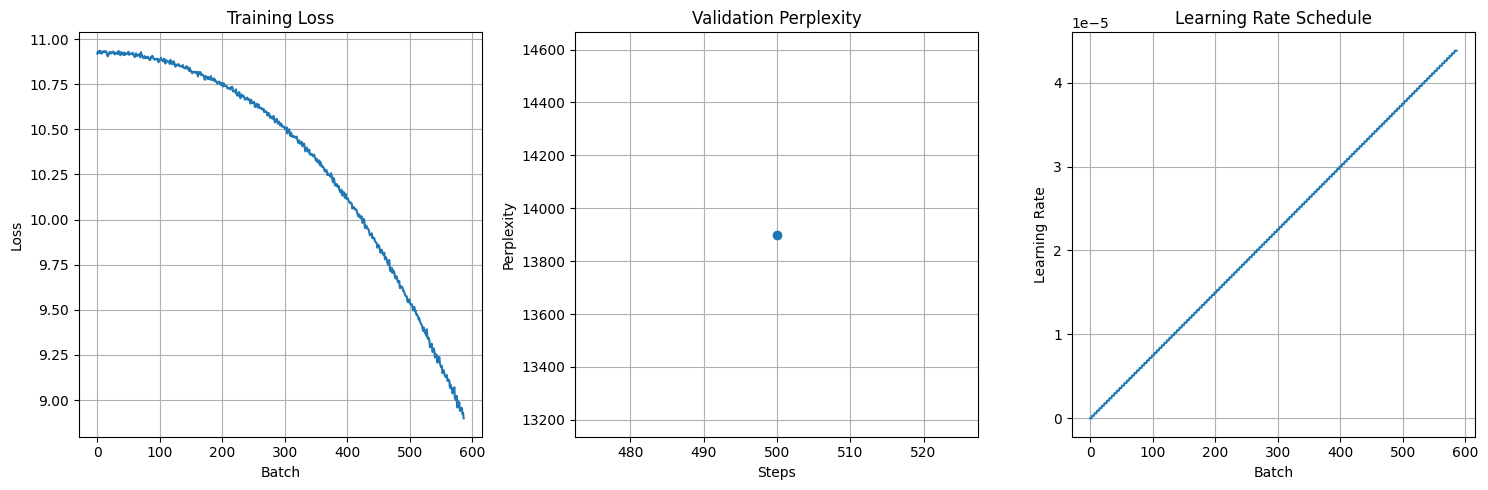

In [12]:
# -----------------------------------------------------------------------------
# Train the Reservoir Model
# -----------------------------------------------------------------------------

# Train the model
training_history = train_optimized_reservoir_model(
    optimized_model, 
    train_loader, 
    val_loader, 
    optimized_reservoir_config,
    tokenizer,
    SHARED_CONFIG
)

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(training_history['train_losses'])
plt.title('Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(training_history['steps'], training_history['val_perplexities'], marker='o')
plt.title('Validation Perplexity')
plt.xlabel('Steps')
plt.ylabel('Perplexity')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(training_history['learning_rates'])
plt.title('Learning Rate Schedule')
plt.xlabel('Batch')
plt.ylabel('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.show()

# Save the model
torch.save(optimized_model.state_dict(), optimized_reservoir_config['SAVE_PATH'])

In [ ]:


# Generate some comparison text with the same prompt
print("=" * 80)
print("Model Comparison - Text Generation")
print("=" * 80)

prompt = "Once upon a time, there was a little"
print(f"Prompt: '{prompt}'\n")

# Generate from Reservoir model
reservoir_text = generate_from_reservoir(
    optimized_model, 
    prompt, 
    SHARED_CONFIG['MAX_OUT_TOKENS'], 
    optimized_reservoir_config,
    tokenizer
)
print("Reservoir Model Output:")
print("-" * 50)
print(reservoir_text)
print("\n")



Model Comparison - Text Generation
Prompt: 'Once upon a time, there was a little'

Reservoir Model Output:
--------------------------------------------------
Once upon a time, there was a little
 lake Tim empty They?" came grantedI make and
 mind home why home and. sad. love. said, the he she seen shining why showed. more. said. frame on Lily: saidYes
.Once why wasOnce always
't- Tim, had came excited was seen.
 likedOnce came make was to- had the the most and the, he lake forest the she everyone was the always he was play ice onBobSoYes,- and forest play came school about


